# Data profiling

In [84]:
from support_functions import log_progress, clean_drugbank, query_chembl
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import functools

## 0. Lookup known targets

In [2]:
# load perturbation info
pert_info_1 = pd.read_csv('data/GSE92742_Broad_LINCS_pert_info.txt', sep='\t', header=0)
pert_info_2a = pd.read_csv('data/GSE70138_Broad_LINCS_pert_info.txt', sep='\t', header=0)
all_pert_info = pd.concat([pert_info_1, pert_info_2a], ignore_index=True)

In [3]:
# lookup cpd inchi keys
all_cpd_pert_info = all_pert_info[all_pert_info.pert_type == 'trt_cp']
all_cpd_inchis = all_cpd_pert_info[['pert_id','inchi_key']].set_index('pert_id').copy()
# remove duplicates, store as series
all_cpd_inchis = all_cpd_inchis[~all_cpd_inchis.index.duplicated()].inchi_key

### 0a. Lookup Drugbank targets

In [4]:
# lookup and store drugbank targets as dictionary: { inchi: [targets]}
db_db_path = 'data/full_drugbank_database.xml'
drugbank_target_dict = clean_drugbank(db_db_path)

KeyboardInterrupt: 

In [ ]:
# save to file
filename = 'checkpoint_files/drugbank_target_dict.sav'
pickle.dump(drugbank_target_dict, open(filename, 'wb'))

### 0b. Lookup Chembl targets

In [ ]:
# lookup and store chembl targets as dictionary: { inchi: [targets]}
chembl_target_dict = {}
tested_inchis = [] # b/c this bitch keeps crashing

In [ ]:
# query CHEMBL API using cpd inchi_keys to find human targets
for inchi in log_progress(all_cpd_inchis.values, every=2):
    if inchi not in tested_inchis:
        human_target_genes = query_chembl(inchi)
        if len(human_target_genes) > 0:
            chembl_target_dict[inchi] = human_target_genes
        tested_inchis.append(inchi)

In [ ]:
# save to file
filename = 'checkpoint_files/chembl_target_dict.sav'
pickle.dump(chembl_target_dict, open(filename, 'wb'))

### 0c. Combine targets

In [5]:
drugbank_target_dict = pickle.load(open('checkpoint_files/drugbank_target_dict.sav', 'rb'))
chembl_target_dict = pickle.load(open('checkpoint_files/chembl_target_dict.sav', 'rb'))

combined_target_dict = drugbank_target_dict.copy()
for cpd, chembl_targets in log_progress(chembl_target_dict.items()):
    try:
        drugbank_targets = drugbank_target_dict[cpd]
        combined_targets = list(set().union(chembl_targets,drugbank_targets))
        combined_target_dict[cpd] = combined_targets
    except KeyError:
        combined_target_dict[cpd] = chembl_targets

Widget Javascript not detected.  It may not be installed or enabled properly.


## 1. Identify cpd-KD pairs (pair set 1)

The first of several filtering steps, this set is composed of pairs of known cpd-target interactions where both the cpd and the target KD have been tested in at least one LINCS experiment.

In [7]:
all_kd_pert_info = all_pert_info[all_pert_info.pert_type == 'trt_sh']
kd_genes = all_kd_pert_info.pert_iname.unique()

In [8]:
cpd_1_, target_1_ = [], []
for index, row in log_progress(all_cpd_pert_info.iterrows(), every=1):
    inchi = row.inchi_key
    if inchi in combined_target_dict.keys():
        pert_id = row.pert_id
        targets = combined_target_dict[inchi]
        for target in targets:
            if target in kd_genes:
                cpd_1_.append(pert_id)
                target_1_.append(target)

Widget Javascript not detected.  It may not be installed or enabled properly.


In [9]:
pair_set_1_df = pd.DataFrame({'cpd': cpd_1_, 'target': target_1_})
print('Pair set 1 statistics')
print('No. unique cpds:\t', len(pair_set_1_df.cpd.unique()))
print('No. unique KDs:\t\t', len(pair_set_1_df.target.unique()))
print('No. interactions:\t', pair_set_1_df.shape[0])

## 2. Identify same-cell cpd-KD pairs (pair set 2)

The second of several filtering steps, here we filter out cpd-KD pairs that have not both been tested in at least one common cell line.

In [10]:
# load the signature information
all_sig_info = pd.DataFrame.from_csv('checkpoint_files/all_sig_info.csv')
all_cpd_sig_info = all_sig_info[all_sig_info.pert_type == 'trt_cp']
all_kd_sig_info = all_sig_info[all_sig_info.pert_type == 'trt_sh']

/Users/Nico/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2850: DtypeWarning: Columns (4,6,10) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [11]:
cpd_2_, target_2_, common_cells_2_ = [], [], []
for index, row in log_progress(pair_set_1_df.iterrows(), every=1):
    cpd = row.cpd
    target = row.target
    # extract signatures
    cpd_sigs = all_cpd_sig_info[all_cpd_sig_info.pert_id == cpd]
    kd_sigs = all_kd_sig_info[all_kd_sig_info.pert_iname == target]
    # compare cell lines
    cpd_cells = set(cpd_sigs.cell_id.unique())
    kd_cells = set(kd_sigs.cell_id.unique())
    common_cells = cpd_cells & kd_cells
    if len(common_cells) > 0:
        cpd_2_.append(cpd)
        target_2_.append(target)
        common_cells_2_.append(common_cells)

Widget Javascript not detected.  It may not be installed or enabled properly.


In [12]:
pair_set_2_df = pd.DataFrame({'cpd': cpd_2_, 'target': target_2_})
print('Pair set 2 statistics')
print('No. unique cpds:\t', len(pair_set_2_df.cpd.unique()))
print('No. unique KDs:\t\t', len(pair_set_2_df.target.unique()))
print('No. interactions:\t', pair_set_2_df.shape[0])

Pair set 2 statistics
No. unique cpds:	 1069
No. unique KDs:		 607
No. interactions:	 4139


## 3. Identify cpd-KD pairs with interaction partners (pair set 3)

The third of several filtering steps, here we filter out cpd-KD pairs for which we do not know any interaction partners for the target.

In [13]:
# load STRING 4.0 database
# 355319.0 high confidence interactions for 14893 genes
string_gene_interactions_700 = pd.DataFrame.from_csv('checkpoint_files/string_gene_interactions_700.csv')
string_genes = string_gene_interactions_700.gene_1.unique()

In [14]:
cpd_3_, target_3_, common_cells_3_ = [], [], []
for index, row in log_progress(pair_set_2_df.iterrows(), every=1):
    target = row.target
    if target in string_genes:
        cpd = row.cpd
        common_cells = common_cells_2_[index]
        cpd_3_.append(cpd)
        target_3_.append(target)
        common_cells_3_.append(common_cells)

Widget Javascript not detected.  It may not be installed or enabled properly.


In [15]:
pair_set_3_df = pd.DataFrame({'cpd': cpd_3_, 'target': target_3_})
print('Pair set 3 statistics')
print('No. unique cpds:\t', len(pair_set_3_df.cpd.unique()))
print('No. unique KDs:\t\t', len(pair_set_3_df.target.unique()))
print('No. interactions:\t', pair_set_3_df.shape[0])

Pair set 3 statistics
No. unique cpds:	 1067
No. unique KDs:		 602
No. interactions:	 4118


## 4. Identify cpd-KD pairs with same-cell interaction partner KDs (pair set 4)

The fourth of several filtering steps, here we filter out cpd-KD pairs for which the target's interaction partners were not knocked down in any of the same cells as the cpd-target pair

In [16]:
cpd_4_, target_4_, common_cells_4_, common_partners_4_ = [], [], [], []

for index, row in log_progress(pair_set_3_df.iterrows(), every=1):
    common_cells = common_cells_3_[index]
    target = row.target
    common_partners_dict = {}
    
    # find interaction partner signatures
    partners = string_gene_interactions_700[string_gene_interactions_700.gene_1 == target].gene_2
    partner_sigs = all_kd_sig_info[all_kd_sig_info.pert_iname.isin(partners)]
    
    # group by cell line
    for cell_line in common_cells:
        partner_cell_sigs = partner_sigs[partner_sigs.cell_id == cell_line]
        cell_partners = partner_cell_sigs.pert_iname.unique()
        if len(cell_partners) > 0:
            # store in dictionary
            common_partners_dict[cell_line] = cell_partners
    
    # make sure we have partner KDs in at least one cell line
    if len(common_partners_dict.keys()) > 0:
        common_cells_4 = set(common_partners_dict.keys())
        cpd_4_.append(row.cpd)
        target_4_.append(target)
        common_cells_4_.append(common_cells_4)
        common_partners_4_.append(common_partners_dict)

Widget Javascript not detected.  It may not be installed or enabled properly.


In [17]:
pair_set_4_df = pd.DataFrame({'cpd': cpd_4_, 'target': target_4_})
print('Pair set 4 statistics')
print('No. unique cpds:\t', len(pair_set_4_df.cpd.unique()))
print('No. unique KDs:\t\t', len(pair_set_4_df.target.unique()))
print('No. interactions:\t', pair_set_4_df.shape[0])

Pair set 4 statistics
No. unique cpds:	 1065
No. unique KDs:		 590
No. interactions:	 4086


## 5. Signature quality of cpd (pair set 5)

Now we'll look at how the size of the training set changes as we place more stringent requirements on the quality of the expression signatures for the cpd in the pair. Next we'll enforce the same signature quality requirements on the KD and the interaction partners.

In [18]:
# data quality parameters 
pct_self_rank_cutoff = 0.05
distill_cc_cutoff = 0.2

In [25]:
cpd_5_, target_5_, common_cells_5_, common_partners_5_ = [], [], [], []

for index, row in log_progress(pair_set_4_df.iterrows(), every=1):
    cpd = row.cpd
    target = row.target
    common_cells = common_cells_4_[index]
    
    # new common cells and partners after filtering
    common_cells_5 = set()
    common_partners_dict_5 = {}
    
    # check if criteria are met in each cell line
    for cell_line in common_cells:
        cpd_cell_sigs = all_cpd_sig_info[(all_cpd_sig_info.pert_id == cpd) &
                                         (all_cpd_sig_info.cell_id == cell_line)]
        good_cpd_cell_sigs = cpd_cell_sigs[(cpd_cell_sigs.distil_cc_q75 >= distill_cc_cutoff) &
                                           (cpd_cell_sigs.pct_self_rank_q25 <= pct_self_rank_cutoff)]
        
        # if the cell line has at least one high quality cpd sig
        if len(good_cpd_cell_sigs) > 0:
            common_cells_5.add(cell_line)
            common_partners_dict_5[cell_line] = common_partners_4_[index][cell_line]
        
    # if we have at least one good cell line for the cpd
    if len(common_cells_5) > 0:
        cpd_5_.append(cpd)
        target_5_.append(target)
        common_cells_5_.append(common_cells_5)
        common_partners_5_.append(common_partners_dict_5)

Widget Javascript not detected.  It may not be installed or enabled properly.


In [26]:
pair_set_5_df = pd.DataFrame({'cpd': cpd_5_, 'target': target_5_})
print('Pair set 5 statistics')
print('No. unique cpds:\t', len(pair_set_5_df.cpd.unique()))
print('No. unique KDs:\t\t', len(pair_set_5_df.target.unique()))
print('No. interactions:\t', pair_set_5_df.shape[0])

Pair set 5 statistics
No. unique cpds:	 642
No. unique KDs:		 460
No. interactions:	 2848


## 6. Signature quality of KD (pair set 6)

Now we'll look at how the size of the training set changes as we place more stringent requirements on the quality of the expression signatures for the KD in the pair. Next we'll enforce the same signature quality requirements on the interaction partners.

In [38]:
cpd_6_, target_6_, common_cells_6_, common_partners_6_ = [], [], [], []

for index, row in log_progress(pair_set_5_df.iterrows(), every=1):
    cpd = row.cpd
    target = row.target
    common_cells = common_cells_5_[index]
    
    # new common cells and partners after filtering
    common_cells_6 = set()
    common_partners_dict_6 = {}
    
    # check if criteria are met in each cell line
    for cell_line in common_cells:
        kd_cell_sigs = all_kd_sig_info[(all_kd_sig_info.pert_iname == target) &
                                       (all_kd_sig_info.cell_id == cell_line)]
        good_kd_cell_sigs = kd_cell_sigs[(kd_cell_sigs.distil_cc_q75 >= distill_cc_cutoff) &
                                         (kd_cell_sigs.pct_self_rank_q25 <= pct_self_rank_cutoff)]
        
        # if the cell line has at least one high quality kd sig
        if len(good_kd_cell_sigs) > 0:
            common_cells_6.add(cell_line)
            common_partners_dict_6[cell_line] = common_partners_5_[index][cell_line]
        
    # if we have at least one good cell line for the kd
    if len(common_cells_6) > 0:
        cpd_6_.append(cpd)
        target_6_.append(target)
        common_cells_6_.append(common_cells_6)
        common_partners_6_.append(common_partners_dict_6)

Widget Javascript not detected.  It may not be installed or enabled properly.


In [39]:
pair_set_6_df = pd.DataFrame({'cpd': cpd_6_, 'target': target_6_})
print('Pair set 6 statistics')
print('No. unique cpds:\t', len(pair_set_6_df.cpd.unique()))
print('No. unique KDs:\t\t', len(pair_set_6_df.target.unique()))
print('No. interactions:\t', pair_set_6_df.shape[0])

Pair set 6 statistics
No. unique cpds:	 633
No. unique KDs:		 455
No. interactions:	 2787


## 7. Signature quality of interaction partners (pair set 7)

Now we'll look at how the size of the training set changes as we place more stringent requirements on the quality of the expression signatures for the interaction partners of the target.

In [47]:
cpd_7_, target_7_, common_cells_7_, common_partners_7_ = [], [], [], []

for index, row in log_progress(pair_set_6_df.iterrows(), every=1):
    cpd = row.cpd
    target = row.target
    common_cells = common_cells_6_[index]
    common_partners_dict = common_partners_6_[index]
    
    # new common cells and partners after filtering
    common_cells_7 = set()
    common_partners_dict_7 = {}
    
    # check if criteria are met in each cell line
    for cell_line in common_cells:
        cell_partners = common_partners_dict[cell_line]
        partner_cell_sigs = all_kd_sig_info[(all_kd_sig_info.pert_iname.isin(cell_partners)) &
                                            (all_kd_sig_info.cell_id == cell_line)]
        good_partner_cell_sigs = partner_cell_sigs[(partner_cell_sigs.distil_cc_q75 >= distill_cc_cutoff) &
                                                   (partner_cell_sigs.pct_self_rank_q25 <= pct_self_rank_cutoff)]
        
        # if the cell line has at least one high quality partner sig
        if len(good_partner_cell_sigs) > 0:
            common_cells_7.add(cell_line)
            good_partners = good_partner_cell_sigs.pert_iname.unique()
            common_partners_dict_7[cell_line] = good_partners
        
    # if we have at least one good cell line for the cpd
    if len(common_cells_7) > 0:
        cpd_7_.append(cpd)
        target_7_.append(target)
        common_cells_7_.append(common_cells_7)
        common_partners_7_.append(common_partners_dict_7)

Widget Javascript not detected.  It may not be installed or enabled properly.


In [48]:
pair_set_7_df = pd.DataFrame({'cpd': cpd_7_, 'target': target_7_})
print('Pair set 7 statistics')
print('No. unique cpds:\t', len(pair_set_7_df.cpd.unique()))
print('No. unique KDs:\t\t', len(pair_set_7_df.target.unique()))
print('No. interactions:\t', pair_set_7_df.shape[0])

Pair set 7 statistics
No. unique cpds:	 633
No. unique KDs:		 454
No. interactions:	 2786


In [51]:
# save to file
pickle.dump(pair_set_7_df, open('checkpoint_files/pair_set_7_df.sav', 'wb'))
pickle.dump(common_cells_7_, open('checkpoint_files/common_cells_7_.sav', 'wb'))
pickle.dump(common_partners_7_, open('checkpoint_files/common_partners_7_', 'wb'))

## 8. Cell count anaylsis

In [62]:
# load filtered data
pair_set_7_df = pickle.load(open('checkpoint_files/pair_set_7_df.sav', 'rb'))
common_cells_7_ = pickle.load(open('checkpoint_files/common_cells_7_.sav', 'rb'))
common_partners_7_ = pickle.load(open('checkpoint_files/common_partners_7_', 'rb'))

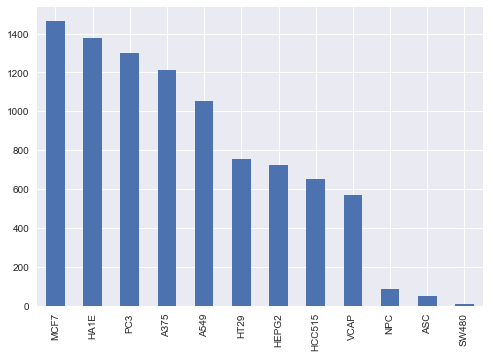

In [99]:
# which cell lines are most common?
all_cell_list = np.array(functools.reduce( lambda x,y: x+y, [ list(s) for s in common_cells_7_ ] ))
cell_line_counts = pd.Series(all_cell_list).value_counts()
cell_line_counts.plot.bar()
plt.show()

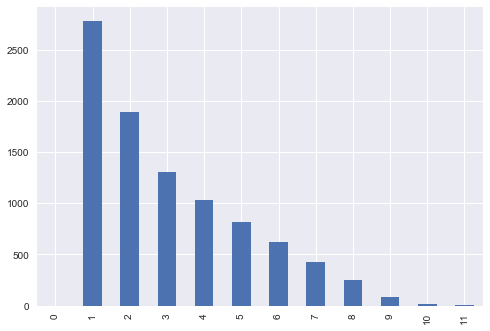

In [128]:
# how many pairs tested in at least n cell lines?
num_common_cells_7 = np.array([ len(cells) for cells in common_cells_7_])
pair_set_7_df['ncells'] = num_common_cells_7
ncell_counts = pair_set_7_df.ncells.value_counts()
cum_ncell_counts = [0]
for i in ncell_counts.index:
    cum_ncell_counts.append(sum(ncell_counts.loc[i:]))
cum_ncell_counts = pd.Series(cum_ncell_counts)
cum_ncell_counts.plot.bar()
plt.show()

In [107]:
a =[]
a[2] = 0

IndexError: list assignment index out of range